# Kono - Github repo health data analyses

## Overview

We seek a means for assessing the health of a github project. As a starting point, we wish to establish metrics and determine insights which are not readily apparent by github's extant visualizations and features. From these, a demo app will be created which incorporates tooling within the [radanalytics.io](http://radanalytics.io) body of work to take advantage of OpenShift and Spark integration.


## Related Work

- [githut](http://githut.info/) is a project which gives a quarterly data on repository languages based on pushes, as opposed to created repos. 

- [github-statistics](https://github.com/AndrewVos/github-statistics) pursued relationships between profanity in commit messages and project activity.

- [open source monthly](http://alysonla.github.io/open-source-monthly/) Tableau Public workbook connected to BigQuery. Shows type of events and activity per login.

- [octoboard](https://github.com/KuiKui/Octoboard) repo's referred URL is now a product site  for a BI dashboard. Uncertain if related, Octoboard was originally name of a github data challenge project. Shows timeline API activity.

- [GDC2](https://github.com/davidfischer/gdc2) geographic info for github repos. Pulls data files, massages, ranks by quanitity of repos in region.

- [Open Source Report Card](https://github.com/dfm/osrc) open source report card, uses deprecated API. Became Gild, which is now 404. 

## Data

### Sources

- github itself provides a REST API for retrieving repo data. 

- [githubarchive](https://www.githubarchive.org) provides GZip compressed JSON files, each containing an hour of github event data.

- BigQuery provides a githubachive-based dataset

### Structure

- Events as defined in the [github event API docs](https://developer.github.com/v3/activity/events/types) are available using all aforementioned sources.

- Non-event data (e.g. repo, org, user details) is available from the github API, depending on privacy settings.


## Repo Health Metrics

Having an understanding of the data sources and availability, our next step was to consider what metrics we could determine such that the health of a repository could be assessed. Put more simply, what makes a healthy repository? 

- **Activity** - A healthy repository does not have tumbleweeds blowing through it. Even projects in maintenance will have just that, maintenance events. As such, a general sum of events broken down by type would be useful.

- **Interest** - A healthy repository inspires others to engage in what's provided. As such, data on number of the number of forks generated would be useful. As well as pull requests, issues, and comments. 

- **Starring** - I am listing these as their own point, since the subjectiveness of starring is apparent. Standalone studies of correlations between starring and more quantitative metrics would be a subject unto themselves.

- **Responsiveness** - A good repository needs an owner/maintainer or group of such who, as needed, responds to communications from the community. Hence, another metric to consider is the response time in addressing pull requests and issues. 

- **Contributor Demeanor** - In my experience, the language one uses in their commit messages can be indicative of the contributor's mindset. For example, a disgruntled contributor might show up in [this project's](http://andrewvos.com/2011/02/21/amount-of-profanity-in-git-commit-messages-per-programming-language) radar. On the other end of the spectrum, commit messages with an excess of emoticons and effusiveness could betray a lack of seriousness about their craft. So sentiment analysis of commit messages in a repo could also be of value. As an aside, this metric resides in waters which can be tough to tread, since one might argue the commit language does not impact the efficacy of the contribution, however its exploring these fuzzy areas that part of what makes what I do so much fun! 

## Approach

Given the metrics of interest, and what data sources are available, it's time to consider how we want to tackle this. First, this table indicates the advantages/disadvantages of the aforementioned sources:

| Source          | Advantage              | Disadvantage                                       |
| :-------------- | :--------------------- | :------------------------------------------------- |
| github API      | Direct from github     | Rate limited                                       |
| github archive  | No rate limit          | Requires initial download investment               |
| BigQuery        | Query driven interface | No 2017 data, analysis amount limited in free tier |

In my case, I wanted to be able to play with the data, making ~~some~~ many exploratory queries that lead to dead ends, back tracking as needed. As a result, the github API data and BigQuery usage limitations were not appealing. Since summary information is available in github's state of the Octoverse [articles](https://octoverse.github.com/)FIXME I chose to focus on data from Q1 2017. So, I began with this command to acquire the data files (note: this will download a large amount of data.)


In [15]:
! mkdir -p ./data/2017
! wget -q -N http://data.githubarchive.org/2017-{01..03}-{01..31}-{0..23}.json.gz -P ./data/2017
! echo "Download complete"

Download complete


In [16]:
! pip install --user nltk
! pip install --user vaderSentiment

Can not perform a '--user' install. User site-packages are not visible in this virtualenv.
Can not perform a '--user' install. User site-packages are not visible in this virtualenv.


In [17]:
%matplotlib inline
import re
import json
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import sys,os,os.path
import math
from matplotlib.ticker import MaxNLocator
from pyspark.sql import SparkSession
sys.path.append(os.path.expanduser('~/.local/lib/python2.7/site-packages'))
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

spark = SparkSession\
        .builder\
        .config("spark.executor.heartbeatInterval","3600s")\
        .appName("kono")\
        .getOrCreate()

sc = spark.sparkContext

### Activity via Number of Events

For a given repo URL, we can parse the repo name, then start working through the data files:

In [18]:
repoURL = 'https://github.com/radanalyticsio/oshinko-s2i'
repoFullName = repoURL.split('github.com/')[-1]

repoAPIURL = 'https://api.github.com/repos/' + repoFullName
repoID = requests.get(repoAPIURL).json()['id']

inFiles = "data/2017/2017*.json.gz"

eventRecords = sc.textFile(inFiles)\
            .map(lambda record: json.loads(record))\
            .filter(lambda record: record['repo']['id'] == repoID)\
            .cache()

er = eventRecords.collect()
df = pd.read_json(json.dumps(er))

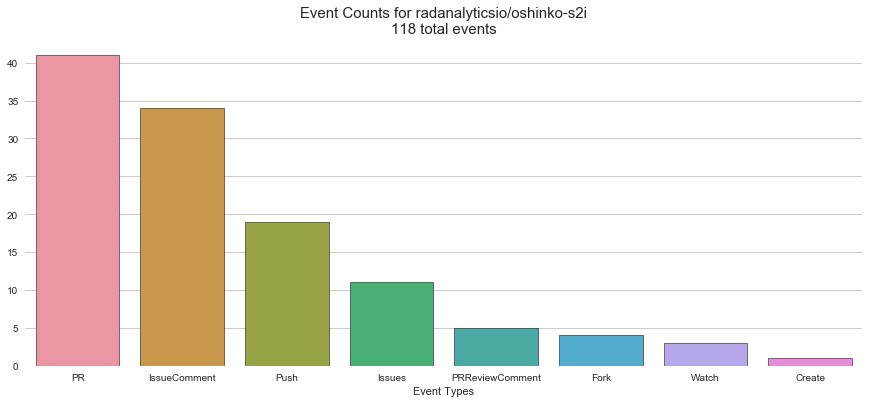

In [195]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 6))
reduceddf = df['type'].map(lambda rec: re.sub(r'Event',r'',rec)).value_counts()

cats = np.arange(len(reduceddf))

ticks = reduceddf.index.map(lambda index: re.sub(r'PullRequest',r'PR',index))
sns.barplot(y=reduceddf.values,x=ticks)
plt.title('Event Counts for ' + repoFullName +'\n'+str(len(df))+' total events',fontsize=15)
ax.set(ylabel="",
       xlabel="Event Types")
sns.despine(left=True, bottom=True)


### Responsivness
GitHub's record timestaps are in the format YYYY-mm-ddThh:mm:ssZ, the following gives a means for parsing timestamps and returning resolution time in days.
 

In [188]:
timeStampFormat = '%Y-%m-%dT%H:%M:%SZ'

def parseGitHubUTCTimeStamp(ts):
    return dt.datetime.strptime(ts, timeStampFormat)

def determineResolutionTime(opened,closed):
    td = closed - opened #rec[1][3]-rec[1][1]
    return td.days

#### Issue Resolution Time
For a given repo, we determine delta between issue posted and issue resolved.


In [189]:
def parseIssuesRecord(record):
    timeStamp = parseGitHubUTCTimeStamp(record['created_at'])
    issueID = record['payload']['issue']['id']
    action = record['payload']['action']
    return [issueID, [action, timeStamp]]

issuesRecords = eventRecords\
        .filter(lambda record: record['type'] == 'IssuesEvent')\
        .cache()

openedRecords = issuesRecords\
        .filter(lambda record: record['payload']['action'] == 'opened')\
        .count()
    
timesToCloseIssues = issuesRecords\
        .filter(lambda record: record['payload']['action'] == 'opened' or record['payload']['action'] == 'closed')\
        .map(lambda issuesRecord: parseIssuesRecord(issuesRecord))\
        .reduceByKey(lambda a,b: a+b)\
        .filter(lambda rec: len(rec[1])>2)\
        .map(lambda rec: determineResolutionTime(rec[1][1],rec[1][3]))\
        .collect()

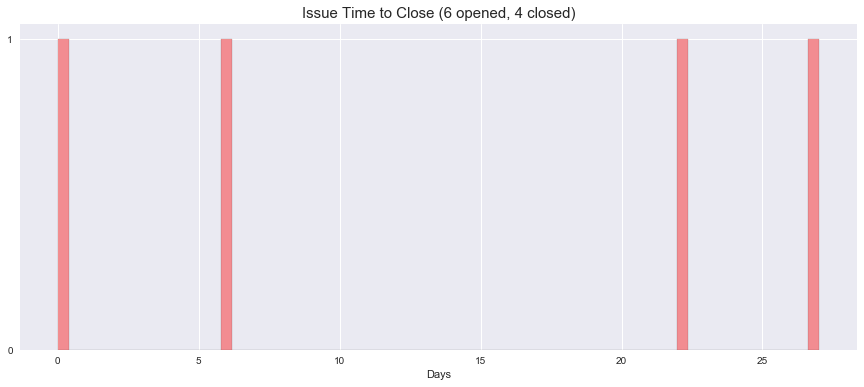

In [190]:
sns.set()
bx = plt.figure(figsize=(15, 6)).gca() 
import math
from matplotlib.ticker import MaxNLocator

sns.distplot(timesToCloseIssues,\
             kde=False,bins=70,color='red')
titleStr=('Issue Time to Close (' + str(openedRecords) + ' opened, ' + str(len(timesToCloseIssues)) + ' closed)')
bx.set(ylabel="",xlabel="Days")
plt.title(titleStr,fontsize=15)
bx.yaxis.set_major_locator(MaxNLocator(integer=True))


### Pull Request Close Time

For a given repo, determine delta between pull request posted and accepted/rejected. 

In [191]:
def parsePullRequestRecord(record):
    timeStamp = parseGitHubUTCTimeStamp(record['created_at'])
    pullRequestID = record['payload']['pull_request']['id']
    action = record['payload']['action']
    merged = record['payload']['pull_request']['merged']
    return [pullRequestID, [action, timeStamp, merged]]

pullRequests = eventRecords\
        .filter(lambda record: record['type'] == 'PullRequestEvent')\
        .cache()

openedPullRequests = pullRequests\
        .filter(lambda record: record['payload']['action'] == 'opened')\
        .count()
    
    
timesToClosePulls = pullRequests\
        .filter(lambda record: record['payload']['action'] == 'opened' or record['payload']['action'] == 'closed')\
        .map(lambda record: parsePullRequestRecord(record))\
        .reduceByKey(lambda a,b: a+b)\
        .filter(lambda rec: len(rec[1])>3)\
        .map(lambda rec: determineResolutionTime(rec[1][1],rec[1][4]))\
        .collect()
        

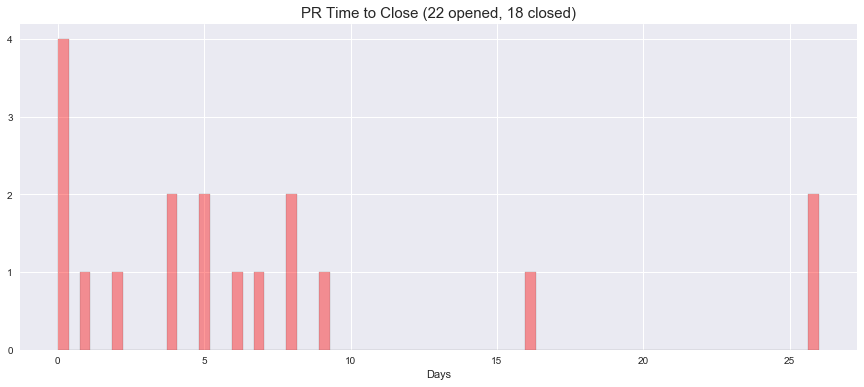

In [192]:
sns.set()
cx = plt.figure(figsize=(15, 6)).gca() 

sns.distplot(timesToClosePulls,\
             kde=False,bins=70,color='red')
titleStr=('PR Time to Close (' + str(openedPullRequests) + ' opened, ' + str(len(timesToClosePulls)) + ' closed)')
cx.set(ylabel="",xlabel="Days")
plt.title(titleStr,fontsize=15)
cx.yaxis.set_major_locator(MaxNLocator(integer=True))


### Sentiments

We can get sentiment intensity values using the [Vader Sentiment](https://github.com/cjhutto/vaderSentiment) package. For an input string, values ranging from 0-1 are output for positive, neutral, and negative sentiments, as well as a composite sentiment based on the three intensities. 

In [193]:
analyzer = SentimentIntensityAnalyzer()

#### Commit Messages

For each commit message, we check the sentiment and plot a pie chart

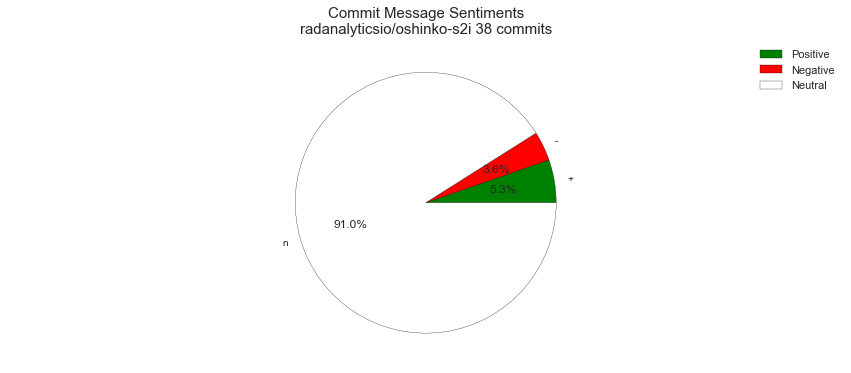

In [194]:
pushPayloads=df[df['type']=='PushEvent']['payload']

neg=0
pos=0
neu=0
numCommits = 0

for p in pushPayloads.keys():
    for cm in pushPayloads[p]['commits']:
        numCommits+=1
        scores=analyzer.polarity_scores(cm['message'])
        neg+=scores['neg']
        pos+=scores['pos']
        neu+=scores['neu']
if(numCommits > 0):
    neg/=numCommits
    pos/=numCommits
    neu/=numCommits
    x_list = [pos,neg,neu]
    label_list = ['+','-','n']
    sns.set_style("whitegrid")
    p1x = plt.figure(figsize=(15, 6)).gca() 
    p1x.axis("equal") 
    p1x.pie(x_list,labels=label_list,autopct="%1.1f%%",colors=['green','red','white'])
    plt.rcParams['patch.linewidth'] = 0.5
    plt.rcParams['patch.force_edgecolor'] = True
    plt.title("Commit Message Sentiments\n"+repoFullName+' '+str(numCommits)+' commits',fontsize=15)
    p1x.legend(['Positive','Negative','Neutral'],fontsize=11)
else:
    print("No commit messages")
    
        

#### Issue Comments

For each issue comment, we check the sentiment and plot a pie chart.

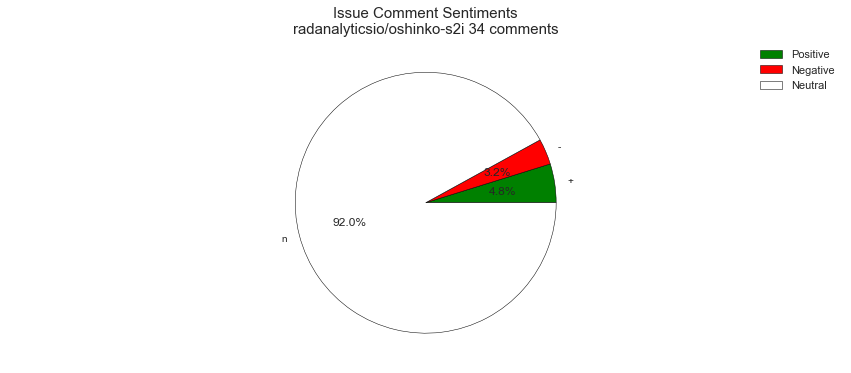

In [180]:
issuePayloads=df[df['type']=='IssueCommentEvent']['payload']

neg=0
pos=0
neu=0
numIssueComments = 0

for p in issuePayloads.keys():
    numIssueComments+=1
    scores=analyzer.polarity_scores(issuePayloads[p]['comment']['body'])
    neg+=scores['neg']
    pos+=scores['pos']
    neu+=scores['neu']

if(numIssueComments > 0):
    neg/=numIssueComments
    pos/=numIssueComments
    neu/=numIssueComments
    x_list = [pos,neg,neu]
    label_list = ['+','-','n']
    sns.set_style("whitegrid")
    p2x = plt.figure(figsize=(15, 6)).gca() 
    p2x.axis("equal") 
    plt.rcParams['patch.linewidth'] = 0.5
    plt.rcParams['patch.force_edgecolor'] = True
    p2x.pie(x_list,labels=label_list,autopct="%1.1f%%",colors=['green','red','white']) 
    plt.title("Issue Comment Sentiments\n"+repoFullName+' '+str(numIssueComments)+' comments',fontsize=15)
    p2x.legend(['Positive','Negative','Neutral'],fontsize=11)
else:
    print("No issue comments")

#### Pull Request Review Comments

For each pull request review comment, we check the sentiment and plot a pie chart.

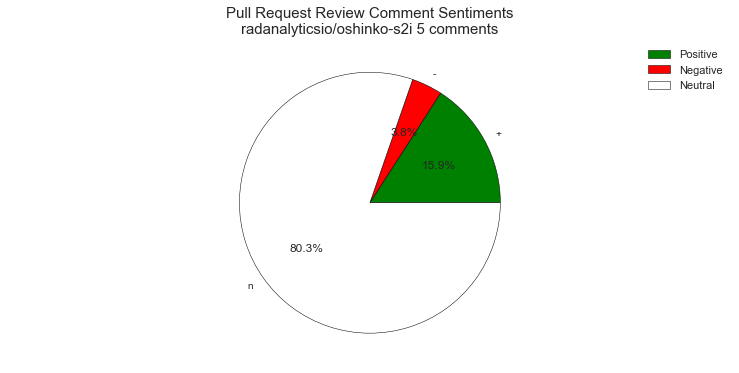

In [182]:
pullRequestReviewPayloads=df[df['type']=='PullRequestReviewCommentEvent']['payload']

neg=0
pos=0
neu=0
numPullRequestReviewComments = 0

for p in pullRequestReviewPayloads.keys():
    numPullRequestReviewComments+=1
    scores=analyzer.polarity_scores(pullRequestReviewPayloads[p]['comment']['body'])
    neg+=scores['neg']
    pos+=scores['pos']
    neu+=scores['neu']
    
if(numPullRequestReviewComments > 0):
    neg/=numPullRequestReviewComments
    pos/=numPullRequestReviewComments
    neu/=numPullRequestReviewComments
    x_list = [pos,neg,neu]
    label_list = ['+','-','n']
    p3x = plt.figure(figsize=(13, 6)).gca() 
    p3x.axis("equal") 
    plt.rcParams['patch.linewidth'] = 0.5
    plt.rcParams['patch.force_edgecolor'] = True
    p3x.pie(x_list,labels=label_list,autopct="%1.1f%%",colors=['green','red','white']) 
    plt.title("Pull Request Review Comment Sentiments\n"+repoFullName+' '+str(numPullRequestReviewComments)+' comments',fontsize=15)
    p3x.legend(['Positive','Negative','Neutral'],fontsize=11)
else:
    print("No pull request review comments")
